# save-PR-stats-sandbox
2.8.23

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy import stats
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# suppressing this CUDA initialization warning I always get
    # this could be dangerous
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# import my modules
sys.path.append('../../../../bin/')
from models.linear import GradNMFImputer
import util_functions
import intermediate_plots

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette()

#### Some configs

In [15]:
# partitioning params
val_frac = 0.3
test_frac = 0.0
# setting this to 0 ensures that no peptides will be filtered out
min_present = 0     # during partitioning
q_anchor=0.35  # these three for MNAR partition 
t_std=0.45
brnl_prob=0.7

# NMF model params
n_factors = 4
tolerance = 0.0001            # 0.0001 is default
max_epochs = 1000             # 1000 is default
learning_rate = 0.01          # 0.01 is default
batch_size = 64               # 64 is default
loss_func = "MSE"

# for determining the ground truth DE peptides
alpha = 0.01
correction = "BH"

# the random number generator
rng = np.random.default_rng(seed=18)

# the random state for the partition
split_rand_state = 18

#### Read in quants matrix, pre-process

In [3]:
# read in 
cond1_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-ADD-quants.csv")
cond2_df = pd.read_csv(
            "../../2022-10-31_SMTG_data/data/SMTG-HCF-low-quants.csv")

# downsample. Really should do this probabilisticly 
# cond1_df = cond1_df[:10000]
# cond2_df = cond2_df[:10000]

# get the list of peptide IDs, or rather transition group IDs
    # these will be the same for the two datasets
peptide_ids = np.array(cond1_df["pids"])

# now remove the peptide ID columns
to_remove = ["pids"]
cond1_df = cond1_df.drop(to_remove, axis=1)
cond2_df = cond2_df.drop(to_remove, axis=1)

# convert to numpy arrays
cond1_quants = np.array(cond1_df)
cond2_quants = np.array(cond2_df)

print("condition 1 quants: ", cond1_quants.shape)
print("condition 2 quants: ", cond2_quants.shape)

condition 1 quants:  (32614, 9)
condition 2 quants:  (32614, 9)


#### Get the ground truth DE peptides

In [17]:
reject_null_gt, pvals_correct = \
        util_functions.find_DE_peptides(
                            cond1_quants, 
                            cond2_quants, 
                            correction, 
                            alpha,
        )
DE_peptides_gt = list(peptide_ids[reject_null_gt])

#### Partition 
MCAR or MNAR. 

In [4]:
# create the combined matrix, to use for imputation 
comb_quants = np.concatenate([cond1_quants, cond2_quants], axis=1)

# this is for eventually separating the reconstructed matrices 
    # into normal and tumor matrices
cols_cutoff = cond1_quants.shape[1]

# MCAR partition 
# train, val, test = util_functions.split(
#                                     comb_quants, 
#                                     val_frac=val_frac,
#                                     test_frac=test_frac, 
#                                     min_present=min_present,
#                                     random_state=split_rand_state,
# )
# MNAR partition 
train, val = util_functions.MNAR_partition_thresholds_matrix(
                                    comb_quants, 
                                    q_anchor=q_anchor, 
                                    t_std=t_std, 
                                    brnl_prob=brnl_prob, 
                                    min_pres=min_present,
                                    rand_state=split_rand_state,
)

#### Get the optimal number of batches for training and eval

In [5]:
# get the optimal number of batches for training
if len(~np.isnan(train)) > 100:
    n_batches = int(np.floor(len(~np.isnan(train)) / batch_size))
    # setting the minimum n_batches to 100
    n_batches = max(n_batches, 100) 
else: 
    n_batches = 1
    
print(n_batches)

509


#### Get the MV fractions from each partition 

In [6]:
# get the missingness fractions
orig_mv_frac = np.count_nonzero(np.isnan(comb_quants)) / comb_quants.size
train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

print("original mv frac: ", np.around(orig_mv_frac, decimals=2))
print("training mv frac: ", np.around(train_mv_frac, decimals=2))
print("validation mv frac: ", np.around(val_mv_frac, decimals=2))

original mv frac:  0.0
training mv frac:  0.26
validation mv frac:  0.74


#### Plot the distribution of the partitions

Text(0, 0.5, 'Counts')

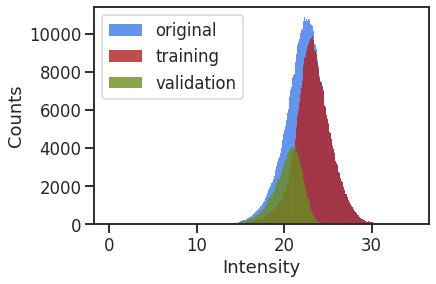

In [7]:
# flatten
quants_rav = comb_quants.ravel()
train_rav = train.ravel()
val_rav = val.ravel()

# get the present values from the original matrix
p_quants_nans = np.isnan(quants_rav)
p_quants_present = quants_rav[~p_quants_nans]

# get present values from the training matrix
train_nans = np.isnan(train_rav)
train_present = train_rav[~train_nans]

# get present values from the validation matrix
val_nans = np.isnan(val_rav)
val_present = val_rav[~val_nans]

quants_max = np.max(p_quants_present)
quants_min = np.min(p_quants_present)

bins_range = np.arange(0, quants_max, 0.1)

plt.figure()
plt.hist(p_quants_present, density=False, bins=bins_range, linewidth=0.01,
         color='cornflowerblue', edgecolor='cornflowerblue', alpha=1.0, label="original")
plt.hist(train_present, density=False, bins=bins_range, linewidth=0.01, 
         color='firebrick', edgecolor='firebrick', alpha=0.8, label="training")
plt.hist(val_present, density=False, bins=bins_range, linewidth=0.01,
        color='olivedrab', edgecolor='olivedrab', alpha=0.8, label="validation")

plt.minorticks_off()

plt.legend()
plt.xlabel("Intensity")
plt.ylabel("Counts")

***

#### NMF impute

In [8]:
# init model 
nmf_model = GradNMFImputer(
                n_rows = train.shape[0], 
                n_cols = train.shape[1], 
                n_factors=n_factors, 
                stopping_tol=tolerance,
                train_batch_size=n_batches, 
                eval_batch_size=n_batches,
                n_epochs=max_epochs, 
                loss_func=loss_func,
                optimizer=torch.optim.Adam,
                optimizer_kwargs={"lr": learning_rate},
                non_negative=True,
                rand_seed=rng.random(),
)
# fit and transform
nmf_recon = nmf_model.fit_transform(train, val)
nmf_full_recon = nmf_model.train_set_transform(train)

  6%|▌         | 57/1000 [01:16<21:06,  1.34s/epoch]

early stopping triggered: standard criteria


#### Get sanity check plots

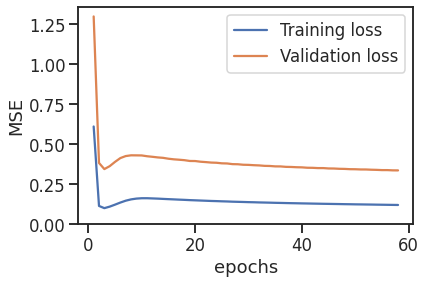

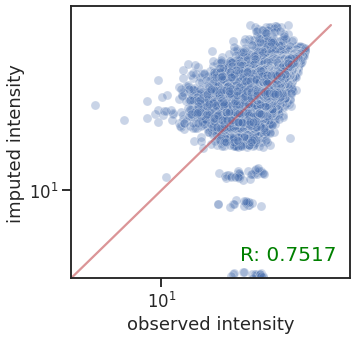

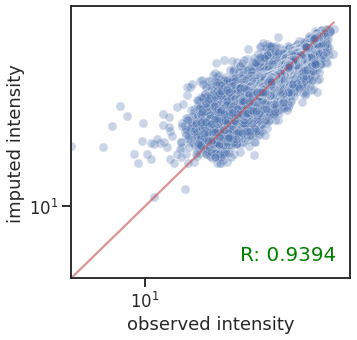

In [9]:
intermediate_plots.plot_train_loss(
            model=nmf_model, 
            PXD="SMTG", 
            n_row_factors=nmf_model.n_row_factors,
            n_col_factors=nmf_model._n_col_factors, 
            model_type="NMF", 
            eval_loss="MSE",
            tail=None,
)                   
intermediate_plots.real_v_imputed_basic(
            recon_mat=nmf_recon, 
            val_mat=val, 
            PXD="SMTG",
            row_factors=nmf_model.n_row_factors,
            col_factors=nmf_model._n_col_factors,
            model_type="NMF",
            log_transform=False,
            tail="valid",
)
intermediate_plots.real_v_imputed_basic(
            recon_mat=nmf_full_recon,
            val_mat=train,
            PXD="SMTG",
            row_factors=nmf_model.n_row_factors,
            col_factors=nmf_model._n_col_factors,
            model_type="NMF", 
            log_transform=False,
            tail="train",
)

## Gaussian random sample impute

In [11]:
# get the column mins
col_min = np.nanmin(train, axis=0)

# get the mean and std of the entire training matrix
train_mean = np.nanmean(train)
train_sd = np.nanstd(train)

# get the indicies of the MVs 
nan_idx = np.where(np.isnan(train))
gsample_recon = train.copy()

# how many total MVs? 
n_mv = len(nan_idx[0])

# fill in the MVs with random draws 
gsample_recon[nan_idx] = rng.normal(
                            loc=np.mean(col_min), 
                            scale=np.std(col_min), 
                            size=n_mv
)

# don't want negative values
gsample_recon = np.abs(gsample_recon)

#### Sample min impute

In [27]:
col_min = np.nanmin(train, axis=0)
nan_idx = np.where(np.isnan(train))
min_recon = train.copy()
# nan_idx[1] -> take index of column
min_recon[nan_idx] = np.take(col_min, nan_idx[1]) 

***

## Get the Precision Recall curve

#### Get column cutoffs

In [28]:
# for the NMF model 
cond1_recon_nmf = nmf_recon[:,0:cols_cutoff]
cond2_recon_nmf = nmf_recon[:,cols_cutoff:]

# for Gaussian sample
cond1_recon_gsample = gsample_recon[:,0:cols_cutoff]
cond2_recon_gsample = gsample_recon[:,cols_cutoff:]

# for Sample min impute
cond1_recon_min = min_recon[:,0:cols_cutoff]
cond2_recon_min = min_recon[:,cols_cutoff:]

#### Get the corrected p-values
And the ground truth labels

In [29]:
r, cp_vals_nmf = util_functions.find_DE_peptides(
                        cond1_recon_nmf, cond2_recon_nmf, 
                        correction, alpha_=alpha)
r, cp_vals_gsample = util_functions.find_DE_peptides(
                        cond1_recon_gsample, cond2_recon_gsample, 
                        correction, alpha_=alpha)
r, cp_vals_min = util_functions.find_DE_peptides(
                        cond1_recon_min, cond2_recon_min, 
                        correction, alpha_=alpha)

# the ground truth labels. True means DE peptide, False means not
gt_labels = reject_null_gt.astype(float)

#### Get the DE probabilities

In [31]:
prob_true_nmf = 1 - cp_vals_nmf
prob_true_gsample = 1 - cp_vals_gsample
prob_true_min = 1 - cp_vals_min

#### Get the Precision Recall stats

In [32]:
pr_nmf, recall_nmf, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_nmf)
pr_gsample, recall_gsample, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_gsample)
pr_min, recall_min, t = precision_recall_curve(
                        y_true=gt_labels, probas_pred=prob_true_min)

# get the AUCs
nmf_auc = np.around(auc(recall_nmf, pr_nmf), 2)
gsample_auc = np.around(auc(recall_gsample, pr_gsample), 2)
min_auc = np.around(auc(recall_min, pr_min), 2)

In [33]:
print(len(pr_nmf))
print(len(recall_nmf))

print(len(pr_gsample))
print(len(recall_gsample))

print(len(pr_min))
print(len(recall_min))

17957
17957
13485
13485
13383
13383


#### Create a Precision Recall results dataframe

In [34]:
# Save the Precision Recall results to a dataframe
cols = ["NMF precision", "kNN precision", "missForest precision", 
        "Sample min precision", "Gaussian sample precision", 
        "No impute precision", "NMF recall", "kNN recall", 
        "missForest recall", "Sample min recall",
        "Gaussian sample recall", "No impute recall", 
        "NMF AUC", "kNN AUC", "missForest AUC", 
        "Sample min AUC", "Gaussian sample AUC", "No impute AUC"]

pr_results_df = pd.DataFrame(columns = cols)
pr_results_df

,NMF precision,kNN precision,missForest precision,Sample min precision,Gaussian sample precision,No impute precision,NMF recall,kNN recall,missForest recall,Sample min recall,Gaussian sample recall,No impute recall,NMF AUC,kNN AUC,missForest AUC,Sample min AUC,Gaussian sample AUC,No impute AUC


In [59]:
# get the max length of any PR results array
max_len = np.max([len(pr_nmf), len(pr_gsample), len(pr_min)])

# figure out how many NaNs to add to each array
nmf_n_toadd = max_len - len(pr_nmf)
gsamp_n_toadd = max_len - len(pr_gsample)
min_n_toadd = max_len - len(pr_min)

# generate NaN arrays
nmf_toadd = np.zeros(nmf_n_toadd)
nmf_toadd[:] = np.nan

gsamp_toadd = np.zeros(gsamp_n_toadd)
gsamp_toadd[:] = np.nan

min_toadd = np.zeros(min_n_toadd)
min_toadd[:] = np.nan

# make additions
pr_nmf = list(pr_nmf) + list(nmf_toadd)
pr_gsample = list(pr_gsample) + list(gsamp_toadd)
pr_min = list(pr_min) + list(min_toadd)

In [60]:
pr_results_df["NMF precision"] = pr_nmf
pr_results_df["Gaussian sample precision"] = pr_gsample
pr_results_df["Sample min precision"] = pr_min

In [61]:
pr_results_df

,NMF precision,kNN precision,missForest precision,Sample min precision,Gaussian sample precision,No impute precision,NMF recall,kNN recall,missForest recall,Sample min recall,Gaussian sample recall,No impute recall,NMF AUC,kNN AUC,missForest AUC,Sample min AUC,Gaussian sample AUC,No impute AUC
0,0.086610,NaN,NaN,0.084315,0.084289,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.086587,NaN,NaN,0.084294,0.084261,NaN,0.999636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.086617,NaN,NaN,0.084297,0.084263,NaN,0.999636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.086619,NaN,NaN,0.084300,0.084271,NaN,0.999636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.086622,NaN,NaN,0.084336,0.084243,NaN,0.999636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17952,1.000000,NaN,NaN,NaN,NaN,NaN,0.004001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17953,1.000000,NaN,NaN,NaN,NaN,NaN,0.003274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17954,1.000000,NaN,NaN,NaN,NaN,NaN,0.002910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17955,1.000000,NaN,NaN,NaN,NaN,NaN,0.002546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
